# **Neural Networks - Deep Learning**
## Exercise 1 - Multiclass Classification using MLP Models

### Georgios Tsoumplekas, AEM: 9359

# **Part 0:** Laying the ground

## **Imports**

In [4]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras import models,layers
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import numpy as np
import time

from matplotlib import pyplot as plt

In [17]:
!pip install -q -U keras-tuner

import keras_tuner as kt

     |████████████████████████████████| 98 kB 4.2 MB/s 


## **Testing that GPU is working**

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## **Preprocesing of the MNIST dataset**

In [7]:
#MNIST dataset parameters
num_classes = 10 #total classes: digits 0-9
num_features = 784 #data features (28x28 pixels image)

In [14]:
#Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape", x_train.shape) 
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

#Convert to float32
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

#Flatten image to 1-D vector
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

#Normalize to [0,1]
x_train, x_test = x_train/255.0, x_test/255.0

#Labels without the one-hot encoding (needed later)
y_train_raw = y_train
y_test_raw = y_test

#One-hot encoding (to increase performance)
y_train, y_test = np_utils.to_categorical(y_train, num_classes), np_utils.to_categorical(y_test, num_classes)

x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
y_test shape (10000,)


# **Part 1:** Basic models and techniques

## **The base model**

First of all, we will create and train a simple MLP model to fit our dataset. This model will be used as a base model with which all other models we will create are going to be compared to.

More specifically, this model will have one hidden layer with 256 neurons and an output layer of 10 neurons (one for each label). The default settings of Keras fit function are used here for simplicity. The model is trained for 10 epochs using minibatches of 256 samples.

In [ ]:
base_model = models.Sequential()

base_model.add(layers.Dense(256, input_shape=(num_features,), activation='relu'))
base_model.add(layers.Dense(10))

base_model.summary()

base_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
base_model.fit(x_train, y_train, epochs=10, batch_size=256, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

score = base_model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               200960    
                                                                 
 dense_13 (Dense)            (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
235/235 [==============================] - 2s 4ms/step - loss: 0.3455 - accuracy: 0.9042
Epoch 2/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1553 - accuracy: 0.9560
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1087 - accuracy: 0.9692
Epoch 4/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0826 - accuracy: 0.9758
Epoch 5/10
235/235 [========================

As we can see, the model achieves a pretty good accuracy on the test set that is a bit smaller than the one on the training set (meaning that we may have a little bit of overfitting).

The training time is pretty decent, too, however a simple step to achieve even better performance (speed-wise) would be to use techniques such as feature selection or feature extraction to speed up the training process.


## **Feature Selection**





Feauture selection is usually a preprocessing step of the whole procedure with which we select only some of the feautures we have. The reason to do this is because sometimes some features are strongly correlated with one another and having both of them provides no additional useful information for the model to learn.

 Using a criterion (such as information gain, chi square test or other statistical criteria) we can eliminate the redundant features and keep only the important ones. In this case, we use the chi square test and keep only a percentage of the features with the best scores.

### **Case 1:** 60% of the features used to train our model



In [ ]:
features_perc = SelectPercentile(chi2,percentile=60).fit(x_train, y_train)
x_train_feat_sel = features_perc.transform(x_train)
x_test_feat_sel = features_perc.transform(x_test)

perc_model_1 = models.Sequential()

perc_model_1.add(layers.Dense(256, input_shape=(x_train_feat_sel[1].shape), activation='relu'))
perc_model_1.add(layers.Dense(10))

perc_model_1.summary()

perc_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
perc_model_1.fit(x_train_feat_sel, y_train, epochs=10, batch_size=256, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

score = perc_model_1.evaluate(x_test_feat_sel, y_test)
print('Test accuracy:', score[1])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               120576    
                                                                 
 dense_15 (Dense)            (None, 10)                2570      
                                                                 
Total params: 123,146
Trainable params: 123,146
Non-trainable params: 0
_________________________________________________________________
Training time: 10.822318315505981s

313/313 [==============================] - 1s 3ms/step - loss: 0.0842 - accuracy: 0.9743
Test accuracy: 0.9743000268936157


As we can see, using only 60% of the initial features we can achieve a slightly better performance while also reducing the size of our model (meaning faster training).

### **Case 2:** 80% of the features used to train our model

In [ ]:
features_perc = SelectPercentile(chi2,percentile=80).fit(x_train, y_train)
x_train_feat_sel = features_perc.transform(x_train)
x_test_feat_sel = features_perc.transform(x_test)

perc_model_2 = models.Sequential()

perc_model_2.add(layers.Dense(256, input_shape=(x_train_feat_sel[1].shape), activation='relu'))
perc_model_2.add(layers.Dense(10))

perc_model_2.summary()

perc_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
perc_model_2.fit(x_train_feat_sel, y_train, epochs=10, batch_size=256, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

score = perc_model_2.evaluate(x_test_feat_sel, y_test)
print('Test accuracy:', score[1])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               160768    
                                                                 
 dense_17 (Dense)            (None, 10)                2570      
                                                                 
Total params: 163,338
Trainable params: 163,338
Non-trainable params: 0
_________________________________________________________________
Training time: 8.211104154586792s

313/313 [==============================] - 1s 3ms/step - loss: 0.0673 - accuracy: 0.9793
Test accuracy: 0.9793000221252441


A we can see here, the performance of this model on the test set is slightly worse than the one where we kept 60% of the features. That might be happening because now we still have some redundant features which cause our model to overfit in the training set.

However, we can see that in both cases despite the fact that we used only a subset of the total features we managed to achieve better performance (both complexity and accuracy-wise) than the base model.

Now let's try a more advanced approach using feature extraction.

## **Feature extraction**

In feature extraction our goal is to create some new features which occur from the initial set of features in such a way that we encapsulate most of the information held by the initial features by only a small number of the newly created ones. A common method to achieve this is using PCA.

In [15]:
pca = PCA(n_components=0.9).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

print("We extract {} feautures from the original {}.".format(x_train_pca.shape[1],x_train.shape[1]))

pca_model = models.Sequential()

pca_model.add(layers.Dense(256, input_shape=(x_train_pca[1].shape), activation='relu'))
pca_model.add(layers.Dense(10))

pca_model.summary()

pca_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
pca_model.fit(x_train_pca, y_train, epochs=10, batch_size=256, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

score = pca_model.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

We extract 87 feautures from the original 784.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               22528     
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 25,098
Trainable params: 25,098
Non-trainable params: 0
_________________________________________________________________
Training time: 6.882077217102051s

313/313 [==============================] - 1s 1ms/step - loss: 0.0605 - accuracy: 0.9824
Test accuracy: 0.9824000000953674


Our goal was that the new components (features) achieve 90% explained variance of the initial ones. We see that by creating only 87 of them we can achieve this number (roughly 1/10th of the initial 784 features). 

As a result what we get is a model that is far more simple than the base model and manages to achieve higher accuracy on the test set.

It is clear that necessary preprocessing ofthe data usning techniques as the ones mentioned above can help us create models that are not only simpler but also better at performance.

### kNN and Nearest Centroid models

For the sake of comparison, we will fit some simple models to our dataset using the kNN and the Nearest Centroid algorithms.

### **Case 1:** Nearest Neighbor with 1 neighbor 

In [ ]:
knn_1 = KNeighborsClassifier(n_neighbors=1, p=2)

start = time.time()

knn_1.fit(x_train_pca, y_train)

end = time.time()
print("Training time: {}s\n".format(end-start))

start = time.time()

score = knn_1.score(x_test_pca, y_test)

end = time.time()
print("Testing time: {}s\n".format(end-start))

print("For the 1-NN classifier with Euclidean distance metric used accuracy is: {}".format(score))

Training time: 0.04793596267700195s

Testing time: 15.30520749092102s

For the 1-NN classifier with Euclidean distance metric used accuracy is: 0.9734


We can see that the kNN algorithm has a small training time but a rather big evaluation-on-the-test-set time without achieving the performance of the previous MLP models.

### **Case 2:** Nearest Neighbor with 3 neighbors 

In [ ]:
knn_3 = KNeighborsClassifier(n_neighbors=3, p=2)

start = time.time()

knn_3.fit(x_train_pca, y_train)

end = time.time()
print("Training time: {}s\n".format(end-start))

start = time.time()

score = knn_3.score(x_test_pca, y_test)

end = time.time()
print("Testing time: {}s\n".format(end-start))

print("For the 3-NN classifier with Euclidean distance metric used accuracy is: {}".format(score))

Training time: 0.0455474853515625s

Testing time: 18.74470043182373s

For the 3-NN classifier with Euclidean distance metric used accuracy is: 0.9723


As we can see, adding more neighbors really doesn't help us since the performance is still worse than that of the MLP models' and the execution time is bigger.

### **Case 3:** Nearest Class Centroid with L2 distance metric used

In [ ]:
ncc = NearestCentroid(metric='euclidean')

start = time.time()

ncc.fit(x_train_pca, y_train_raw)

end = time.time()
print("Training time: {}s\n".format(end-start))

start = time.time()

score = ncc.score(x_test_pca, y_test_raw)

end = time.time()
print("Testing time: {}s\n".format(end-start))

print("For the Nearest Centroid classifier with L2 distance metric used accuracy is: {}".format(score))

Training time: 0.02553534507751465s

Testing time: 0.009743213653564453s

For the Nearest Centroid classifier with L2 distance metric used accuracy is: 0.8196


The benefit of this algorithm is its really fast training and evaluation time. However, its performance is clearly worse.

Now, some argue that using the Euclidean distance in high dimensionality spaces leads to worse performance and that in general using L-p norms with small p values leads to better results. Let's try the same algorithm using the Manhattan distance (L1 norm, p=1).     

### **Case 4:** Nearest Class Centroid with L1 distance metric used

In [ ]:
ncc = NearestCentroid(metric='manhattan')

start = time.time()

ncc.fit(x_train_pca, y_train_raw)

end = time.time()
print("Training time: {}s\n".format(end-start))

start = time.time()

score = ncc.score(x_test_pca, y_test_raw)

end = time.time()
print("Testing time: {}s\n".format(end-start))

print("For the Nearest Centroid classifier with L2 distance metric used accuracy is: {}".format(score))

Training time: 0.13043880462646484s

Testing time: 0.008463382720947266s

For the Nearest Centroid classifier with L2 distance metric used accuracy is: 0.8042


As we can see, the performance is slightly worse than before meaning that in our case this assumption does not hold.

Let's move on to some more advanced MLP models. For all models used from now on, we are using the transformed data that occured from applying the PCA algorithm.

## **Model 1:** Trying different learning rates and algorithms

### **Model 1.1**
2 hidden layers with 512 neurons for the first one and 256 for the second one. Training is done for 50 epochs, Adam optimizer used with learning rate of 0.001.

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 512)               45056     
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dense_24 (Dense)            (None, 10)                2570      
                                                                 
Total params: 178,954
Trainable params: 178,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
188/188 [==============================] - 1s 5ms/step - loss: 0.3284 - accuracy: 0.9088 - val_loss: 0.1362 - val_accuracy: 0.9606
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1026 - accuracy: 0.9706 - val_loss: 0.0975 - val_accuracy: 0.9719
Epoch 3/50
188/188 [=======

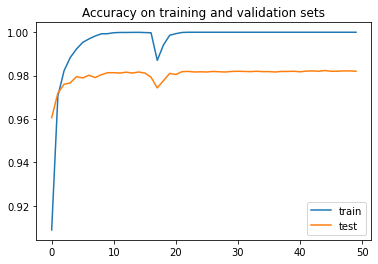

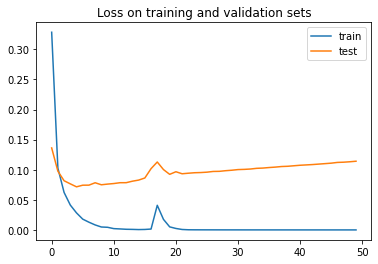

313/313 [==============================] - 1s 3ms/step - loss: 0.0965 - accuracy: 0.9840
Test accuracy: 0.984000027179718


In [ ]:
model_1 = models.Sequential()

model_1.add(layers.Dense(512, input_shape=(x_train_pca[1].shape), activation='relu'))
model_1.add(layers.Dense(256, activation='relu'))
model_1.add(layers.Dense(10))

model_1.summary()

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = model_1.fit(x_train_pca, y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure(1)
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure(2)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = model_1.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

It is clear that this model achieves higher accuracy than the previous models but at the cost of greater complexity. As we can see form the learning curves, the value of the loss function in the validation set starts to increase after some epochs meaning that we have overfitting. We can tackle this problem using various tecniques as will be shown later.

### **Model 1.2**

Now, let's see what happens using the exact same model but training it using a bigger learning rate of 0.01.


Epoch 1/50
188/188 [==============================] - 1s 6ms/step - loss: 0.1292 - accuracy: 0.9672 - val_loss: 0.1306 - val_accuracy: 0.9637
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0764 - accuracy: 0.9771 - val_loss: 0.1190 - val_accuracy: 0.9707
Epoch 3/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0682 - accuracy: 0.9802 - val_loss: 0.1231 - val_accuracy: 0.9684
Epoch 4/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0620 - accuracy: 0.9820 - val_loss: 0.1423 - val_accuracy: 0.9694
Epoch 5/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0634 - accuracy: 0.9820 - val_loss: 0.1715 - val_accuracy: 0.9646
Epoch 6/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0706 - accuracy: 0.9821 - val_loss: 0.1496 - val_accuracy: 0.9696
Epoch 7/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0555 - accuracy: 0.9849 - val_loss: 0.1726 - val_accuracy: 0.9684
Epoch 

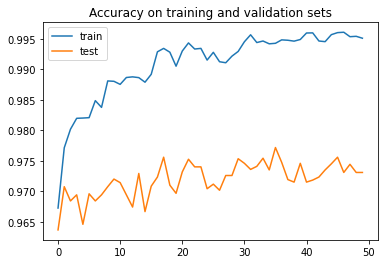

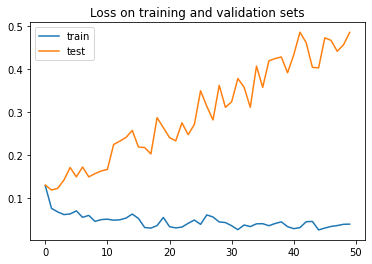

313/313 [==============================] - 1s 3ms/step - loss: 0.4538 - accuracy: 0.9744
Test accuracy: 0.974399983882904


In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = model_1.fit(x_train_pca, y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure(3)
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure(4)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = model_1.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

First of all we notice that the performance of the model on the test set is worse than the previous one meaning a smaller learning rate is more appropriate.

Moreover, it is clear that due to the higher learning rate the algorithm oscilates more making convergence more difficult and causing the spikes we see in the learning curves.

Finally, it is also pretty clear that the model is overfitting even more than before since the value of the loss function in the validation set increases instead of decreasing.

### **Model 1.3**

Let's try training the same model using a different algorithm this time. We will try the Stochastic Gradient Descent (SGD) algorithm with momentum. Momentum helps accelerate the learning process by "remembering" the previous steps that the algorithm made.

Epoch 1/50
188/188 [==============================] - 1s 6ms/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.4257 - val_accuracy: 0.9744
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.4254 - val_accuracy: 0.9744
Epoch 3/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.4253 - val_accuracy: 0.9743
Epoch 4/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.4252 - val_accuracy: 0.9743
Epoch 5/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.4249 - val_accuracy: 0.9743
Epoch 6/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.4248 - val_accuracy: 0.9743
Epoch 7/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.4246 - val_accuracy: 0.9743
Epoch 

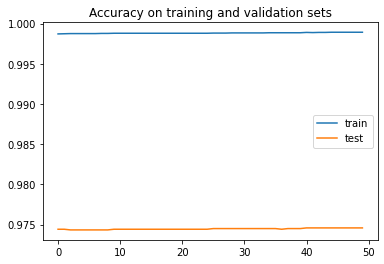

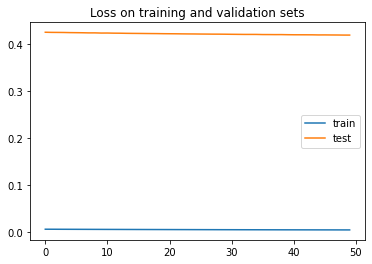

313/313 [==============================] - 1s 3ms/step - loss: 0.3998 - accuracy: 0.9767
Test accuracy: 0.9767000079154968


In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = model_1.fit(x_train_pca, y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure(3)
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure(4)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = model_1.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

Although there is no visible indication of overfitting for this model we can see that it is still underperforming in comparison to model 1.1.

So, for now, let's keep the Adam algorithm with learning rate 0.001 as our training technique.

## **Model 2:** Weight Initalization

One typical problem in deep neural networks is that of vanishing or exploding gradients. This causes the weights of the neurons to either become really big or go to zero after training and cause underperformance of the model. This problem is usually caused due to wrong initialization of the weights of the network. 

A way to prevent this is by properly initialiazing the weights in a way that the mean of activations is zero and the variance of activations stays the same across the layers. Here, we use the He Normal initialization to achieve this.

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 512)               45056     
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dense_30 (Dense)            (None, 10)                2570      
                                                                 
Total params: 178,954
Trainable params: 178,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
188/188 [==============================] - 1s 5ms/step - loss: 0.3139 - accuracy: 0.9066 - val_loss: 0.1411 - val_accuracy: 0.9588
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1088 - accuracy: 0.9689 - val_loss: 0.0998 - val_accuracy: 0.9700
Epoch 3/50
188/188 [=======

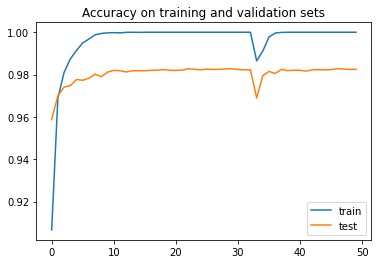

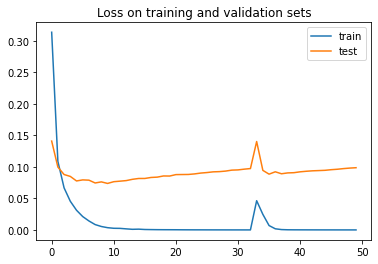

313/313 [==============================] - 1s 3ms/step - loss: 0.0805 - accuracy: 0.9844
Test accuracy: 0.9843999743461609


In [ ]:
model_2 = models.Sequential()

model_2.add(layers.Dense(512, input_shape=(x_train_pca[1].shape), activation='relu',
                        kernel_initializer=initializers.HeNormal()))

model_2.add(layers.Dense(256, activation='relu',
                        kernel_initializer=initializers.HeNormal()))

model_2.add(layers.Dense(10))

model_2.summary()

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = model_2.fit(x_train_pca, y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure(5)
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure(6)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = model_2.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

The network is not actually deep enough to have problems with exploding or vanishing gradients, so we don't really notice a significant difference in results compared to model 1.1.

Now, it's time time to deal with overfitting.

## **Model 3:** L1-Regularization of the weights

Regularization of the weights is used to control the model's complexity and avoid overfitting. The idea behind L1 and L2 regularization is to modify the cost function so that bigger weights cause the cost function to get bigger values. Eventually, in L1 regularization some weights will get 0 values meaning that the connection of this neuron is not active. The cost function only increases by a small percentage of the L1 norm of the weights, here we use a factor of a=0.01.

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 512)               45056     
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dense_33 (Dense)            (None, 10)                2570      
                                                                 
Total params: 178,954
Trainable params: 178,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
188/188 [==============================] - 2s 6ms/step - loss: 42.8515 - accuracy: 0.7221 - val_loss: 8.7525 - val_accuracy: 0.7793
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 3.4149 - accuracy: 0.7859 - val_loss: 1.4495 - val_accuracy: 0.8232
Epoch 3/50
188/188 [======

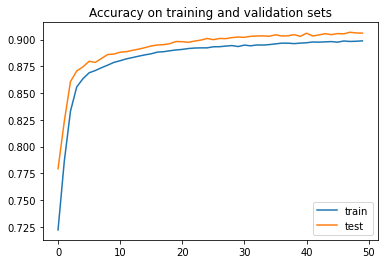

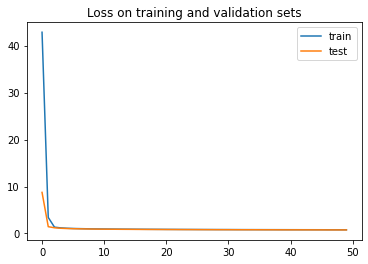

313/313 [==============================] - 1s 3ms/step - loss: 0.7694 - accuracy: 0.9032
Test accuracy: 0.9031999707221985


In [ ]:
model_3 = models.Sequential()

model_3.add(layers.Dense(512, input_shape=(x_train_pca[1].shape), activation='relu',
                         kernel_regularizer=regularizers.l1(0.01),
                        kernel_initializer=initializers.HeNormal()))

model_3.add(layers.Dense(256, activation='relu',
                         kernel_regularizer=regularizers.l1(0.01),
                        kernel_initializer=initializers.HeNormal()))

model_3.add(layers.Dense(10))

model_3.summary()

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = model_3.fit(x_train_pca, y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure(5)
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure(6)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = model_3.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

As we can see from the learning curves, the cost function seems to decrease in both train and validation sets meaning we have no overfitting. However, it might be the case now that we have underfitting since the accuracy in the validation set is bigger than the accuracy on the training set.

Moreover, this model also seems to underperform due to the lower accuracy that achieves on the test set. Maybe with better fine-tuning of the hyperparameter a we would be able to achieve better performance.

## **Model 4:** L2-Regularization of the weights

Let's try something similar to model 3 but now the weights are penalized in the cost function using their L2 norm. Again we will use a factor a=0.01.

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 512)               45056     
                                                                 
 dense_38 (Dense)            (None, 256)               131328    
                                                                 
 dense_39 (Dense)            (None, 10)                2570      
                                                                 
Total params: 178,954
Trainable params: 178,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
188/188 [==============================] - 2s 6ms/step - loss: 6.8398 - accuracy: 0.8905 - val_loss: 2.0148 - val_accuracy: 0.9341
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 1.0954 - accuracy: 0.9330 - val_loss: 0.6192 - val_accuracy: 0.9425
Epoch 3/50
188/188 [=======

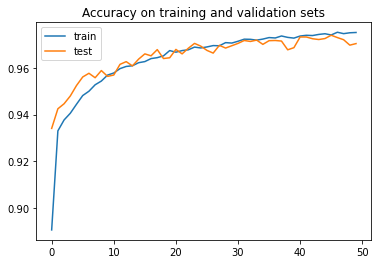

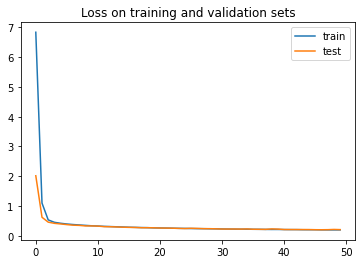

313/313 [==============================] - 1s 3ms/step - loss: 0.2038 - accuracy: 0.9710
Test accuracy: 0.9710000157356262


In [31]:
model_4 = models.Sequential()

model_4.add(layers.Dense(512, input_shape=(x_train_pca[1].shape), activation='relu',
                         kernel_regularizer=regularizers.l2(0.01),
                        kernel_initializer=initializers.HeNormal()))

model_4.add(layers.Dense(256, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01),
                        kernel_initializer=initializers.HeNormal()))

model_4.add(layers.Dense(10))

model_4.summary()

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = model_4.fit(x_train_pca, y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = model_4.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

The results regarding the test set are clearly better than that of model 3 with the L1 regularization but the model is still underperforming compared to some of the previous ones.

We can see here, too, that there might be a little bit of underfitting since the accuracy in the training and the validation set is pretty close to each other.

## **Model 5:** Dropout

One of the most common regularization techniques used is that of dropout. The main idea behind dropout is that we train ensembles of models consisting of all subnetworks of the initial network in order to reduce complexity of the model. These subnetworks are formed by removing non-input units from the parent network using a probabilistic rule.

Due to the fact that exponentially many models are created, a practical way to apply dropout is by evaluating a simple model and applying an apprpriate weight scaling: the weight of each unit is multiplied by the probability of including that same unit.

In our case we use a probablity p=0.2 of dropping a unit.

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 512)               45056     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_41 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_42 (Dense)            (None, 10)                2570      
                                                                 
Total params: 178,954
Trainable params: 178,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
188/188 [===========================

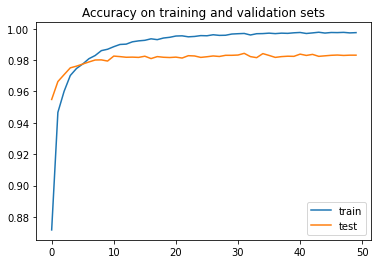

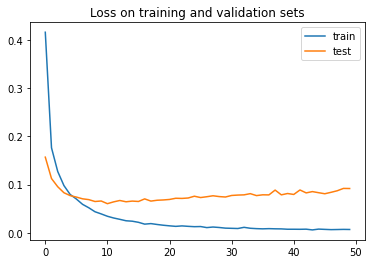

313/313 [==============================] - 1s 3ms/step - loss: 0.0771 - accuracy: 0.9835
Test accuracy: 0.9835000038146973


In [32]:
model_5 = models.Sequential()

model_5.add(layers.Dense(512, input_shape=(x_train_pca[1].shape), activation='relu',
                        kernel_initializer=initializers.HeNormal()))
model_5.add(layers.Dropout(0.2))

model_5.add(layers.Dense(256, activation='relu',
                        kernel_initializer=initializers.HeNormal()))
model_5.add(layers.Dropout(0.2))

model_5.add(layers.Dense(10))

model_5.summary()

model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = model_5.fit(x_train_pca, y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = model_5.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

We can clearly see that compared to model 1.1 the overfitting that we have here is smaller since the rate of increase of the cost function in the validation set is much smaller compared to that in model 1.1. 

Regarding the test set, the accuracy we achieve here is a bit smaller but we are willing ti make this compromise since we can be pretty sure that this model can generalize better with proper hyper-parameter tuning.

## **Model 6:** Early Stopping

One other common technique used to deal with overfitting is that of early stopping. A reason why models with sufficient capacity overfit is because they are trained for too many epochs causing the validation error to increase over time.

So, the optimal thing to do would be to train the model up to that epoch that we achieve the minimum loss function value in the validation set.

In this case, we are training the model for 100 epochs instead of 50 without having to worry if they are too many because due to Early Stopping training will stop at the correct epoch. We set patience at 10 meaning that the algorithm will stop after 10 epochs have passed since we have reached a minimum value of the loss function onthe validation set.

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 512)               45056     
                                                                 
 dense_44 (Dense)            (None, 256)               131328    
                                                                 
 dense_45 (Dense)            (None, 10)                2570      
                                                                 
Total params: 178,954
Trainable params: 178,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 1s 5ms/step - loss: 0.3192 - accuracy: 0.9048 - val_loss: 0.1405 - val_accuracy: 0.9607
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1095 - accuracy: 0.9685 - val_loss: 0.1050 - val_accuracy: 0.9697
Epoch 3/100
188/188 [====

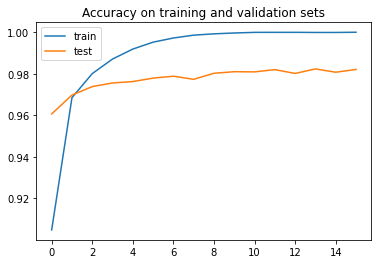

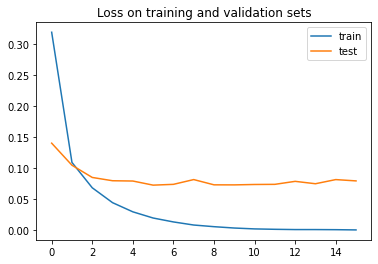

313/313 [==============================] - 1s 3ms/step - loss: 0.0697 - accuracy: 0.9821
Test accuracy: 0.9821000099182129


In [33]:
model_6 = models.Sequential()

model_6.add(layers.Dense(512, input_shape=(x_train_pca[1].shape), activation='relu',
                        kernel_initializer=initializers.HeNormal()))

model_6.add(layers.Dense(256, activation='relu',
                        kernel_initializer=initializers.HeNormal()))

model_6.add(layers.Dense(10))

model_6.summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              mode = 'min',
                                              patience = 10,
                                              verbose=1)

model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = model_6.fit(x_train_pca, y_train, epochs=100, batch_size=256, validation_split=0.2,
                      callbacks=[stop_early], verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = model_6.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

As we can see, training of the model stopped after 16 epochs. Training the model any more than that would probably cause overfitting. As for the accuracy on the test set, we can see that it is pretty close to that of model 1.1 but without overfitting and without having to train it as much.

The fact that we train the model for fewer epochs has also an impact in the training time of the model which is about 3-4 times shorter compared to the previous models.

Comparing all the above regularization methods, dropout seems to have done a better job and will be the one that we will use from now on.

## **Model 7:** Batch Normalization

A common problem in deep neural networks is that due to the fact that all weights are updated simultaneously there is a high degree of interdependency among parameters across layers causing the model to underperform. 

A way to do deal with this is to normalize the activation arguments of the neurons using the mean and variance, which is what batch normalization does.

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 512)               45056     
                                                                 
 batch_normalization_5 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_50 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_51 (Dense)            (None, 10)                2570      
                                                                 
Total params: 182,026
Trainable params: 180,490
Non-t

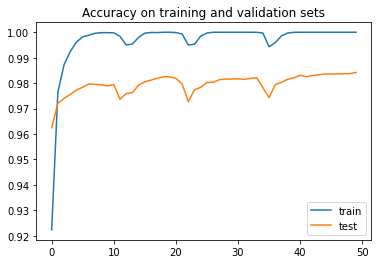

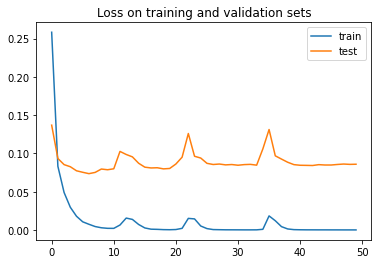

313/313 [==============================] - 1s 4ms/step - loss: 0.0726 - accuracy: 0.9855
Test accuracy: 0.9854999780654907


In [35]:
model_7 = models.Sequential()

model_7.add(layers.Dense(512, input_shape=(x_train_pca[1].shape), activation='relu',
                        kernel_initializer=initializers.HeNormal()))
model_7.add(layers.BatchNormalization())

model_7.add(layers.Dense(256, activation='relu',
                        kernel_initializer=initializers.HeNormal()))
model_7.add(layers.BatchNormalization())

model_7.add(layers.Dense(10))

model_7.summary()

model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = model_7.fit(x_train_pca, y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = model_7.evaluate(x_test_pca, y_test)
print('Test accuracy:', score[1])

As we also mentioned in the weight initialization section, our model is not actually deep enough to see an significant difference when applying such techniques and that seems to be the case here, too. One thing we can mention, though, is that the training time becomes bigger when using batch normalization.

# **Part 2:** Hyper-Parameter Tuning

An important factor and also a challenging problem in Neural Networks is selecting the optimal hyperparameters for the model. Unlike typical parameters such as weights and biases of the model that are learned using algorithms such as Back-Propagation(BK), there aren't similar algorithms to learn hyperparameters.

A common way to find optimal values for the hyperparameters is by grid search and then cross-validation to the models that occur. Other techniques also include random search or using genetic algorithms.

For our model, the hyperparameter that we want to define are the number of neurons in the first and second hidden layer, the learning rate of the Adam algorithm and the probability of the dropout for each layer. The optimizer that we are going to use is the Hyperband optimizer which is a variation of the Hyperband algorithm (Li, Lisha, and Kevin Jamieson 2018), which reduces significantly the time needed to find the optimal hyperparameters.

### **Import add-on for F1-measure**

In [1]:
!pip install tensorflow-addons

import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 8.1 MB/s 


The reason we are using F1 as a metric for our model is because it is generally considered a more robust metric than precision (especially in datasets with imbalanced classes). F1 measure is the harmonic mean of recall and precision.

## **Define the hypermodel**

- Number of neurons in 1st hidden layer: 256 or 512
- Number of neurons in 2nd hidden layer: 256 or 512
- Probability of dropout after each hidden layer: 0,1 or 0,2 or 0,3 or 0,4
- Learning rate of Adam algorithm: 0.1 or 0.01 or 0.001

In [12]:
def model_builder(hp):
    model = models.Sequential()
    
    # Probability p of dropout
    hp_p = hp.Choice('p', values = [0.1, 0.2, 0.3,0.4])
    
    #Number of neurons in the 1st layer is either 256 or 512
    hp_units_1 = hp.Choice('units_1', values = [256, 512])
    model.add(layers.Dense(units = hp_units_1, input_shape=(x_train_pca[1].shape), activation = 'relu',
                             kernel_initializer = initializers.HeNormal()))
    
    model.add(layers.Dropout(rate=hp_p))
    
    #Number of neurons in the 2nd layer is either 256 or 512
    hp_units_2 = hp.Choice('units_2', values = [256, 512])
    model.add(layers.Dense(units = hp_units_2, activation = 'relu',
                             kernel_initializer = initializers.HeNormal()))
    
    model.add(layers.Dropout(rate=hp_p))
    
    #Output layer
    model.add(layers.Dense(10, kernel_initializer = initializers.HeNormal()))
    
    #Learning rate of Adam to be learned by the hypermodel
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3])
    
    #Build model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=[tfa.metrics.F1Score(10,'macro'),'accuracy'])
    
    return model

## **Find hyperparameters using Hyperband tuner**

Our target is to maximize the accuracy of the model in the validation set.

In [18]:
#Instantiate tuner
tuner = kt.Hyperband(model_builder,
                      objective = kt.Objective('val_accuracy', direction = 'max'),
                      max_epochs = 100,
                      factor = 3)

We will use early stopping to speed-up the procedure even more and avoid overfitting.

In [19]:
#Early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              mode = 'min',
                                              patience = 10,
                                              verbose=1)

In [20]:
#Search for the optimal hyperparameters
tuner.search(x_train_pca, y_train, epochs = 100, batch_size=256, validation_split = 0.2, callbacks = [stop_early])

#Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Optimal number of neurons in 1st layer: {}".format(best_hps.get('units_1')))
print("Optimal number of neurons in 2nd layer: {}".format(best_hps.get('units_2')))
print("Optimal value of p for dropout: {}".format(best_hps.get('p')))
print("Optimal value of learning rate: {}".format(best_hps.get('learning_rate')))

Trial 48 Complete [00h 00m 06s]
val_accuracy: 0.9666666388511658

Best val_accuracy So Far: 0.9711666703224182
Total elapsed time: 00h 06m 31s
INFO:tensorflow:Oracle triggered exit
Optimal number of neurons in 1st layer: 512
Optimal number of neurons in 2nd layer: 256
Optimal value of p for dropout: 0.1
Optimal value of learning rate: 0.01


We can see right above the optimal hyperparameters that occured for our model. As we can see, the optimal model is not the most complex of all possible ones and has a rather small dropout rate. As for its learning rate, a rather moderate value has been chosen.

Note that due to the stochastic nature of the whole procedure, it is possible that when re-running the algorithm a different optimal model may occur.

## **Build the model with the optimal hyperparameters**

We have defined the optimal hyperparameters but now we don't know for how many epochs we should train our model. A simple way to find out is to train the model for many epochs (100 here), define in which one we had the smallest value of the cost function in the validation set and then retrain the model for that number of epochs.

Epoch 1/100
188/188 [==============================] - 3s 15ms/step - loss: 0.2625 - f1_score: 0.9220 - accuracy: 0.9228 - val_loss: 0.1205 - val_f1_score: 0.9639 - val_accuracy: 0.9643
Epoch 2/100
188/188 [==============================] - 3s 14ms/step - loss: 0.1162 - f1_score: 0.9646 - accuracy: 0.9649 - val_loss: 0.1152 - val_f1_score: 0.9681 - val_accuracy: 0.9684
Epoch 3/100
188/188 [==============================] - 3s 14ms/step - loss: 0.0940 - f1_score: 0.9710 - accuracy: 0.9713 - val_loss: 0.1210 - val_f1_score: 0.9666 - val_accuracy: 0.9668
Epoch 4/100
188/188 [==============================] - 3s 14ms/step - loss: 0.0925 - f1_score: 0.9738 - accuracy: 0.9740 - val_loss: 0.1209 - val_f1_score: 0.9690 - val_accuracy: 0.9693
Epoch 5/100
188/188 [==============================] - 3s 14ms/step - loss: 0.0824 - f1_score: 0.9764 - accuracy: 0.9766 - val_loss: 0.1121 - val_f1_score: 0.9724 - val_accuracy: 0.9726
Epoch 6/100
188/188 [==============================] - 3s 14ms/step - 

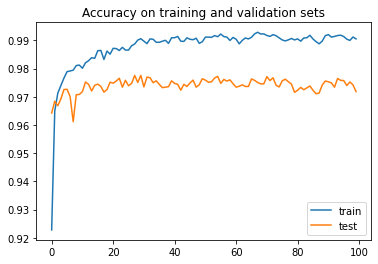

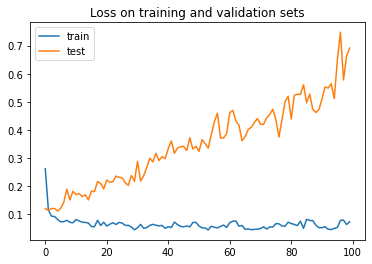

Optimal number of training epochs is: 28


In [21]:
#Build model
model = tuner.hypermodel.build(best_hps)

start = time.time()

history = model.fit(x_train_pca, y_train, epochs = 100, batch_size=256, validation_split = 0.2)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Optimal number of training epochs is: %d" % (best_epoch,))

As we can see, the highest accuracy in the validation set has been achieved in the 28th epoch so we are going to retrain the model for that number of epochs.

Moreover, it is clear that there is no reason to train the model for more epochs since it is visible from the learning curves that the model is heavily overfitting.

## **Re-initialize the model and train it with the optimal number of epochs**

Epoch 1/28
188/188 [==============================] - 3s 15ms/step - loss: 0.2850 - f1_score: 0.9186 - accuracy: 0.9196 - val_loss: 0.1352 - val_f1_score: 0.9555 - val_accuracy: 0.9563
Epoch 2/28
188/188 [==============================] - 3s 14ms/step - loss: 0.1154 - f1_score: 0.9642 - accuracy: 0.9645 - val_loss: 0.1098 - val_f1_score: 0.9688 - val_accuracy: 0.9689
Epoch 3/28
188/188 [==============================] - 3s 14ms/step - loss: 0.0903 - f1_score: 0.9724 - accuracy: 0.9726 - val_loss: 0.1179 - val_f1_score: 0.9675 - val_accuracy: 0.9677
Epoch 4/28
188/188 [==============================] - 3s 14ms/step - loss: 0.0924 - f1_score: 0.9725 - accuracy: 0.9728 - val_loss: 0.1142 - val_f1_score: 0.9713 - val_accuracy: 0.9716
Epoch 5/28
188/188 [==============================] - 3s 13ms/step - loss: 0.0811 - f1_score: 0.9754 - accuracy: 0.9756 - val_loss: 0.1374 - val_f1_score: 0.9676 - val_accuracy: 0.9678
Epoch 6/28
188/188 [==============================] - 3s 14ms/step - loss: 

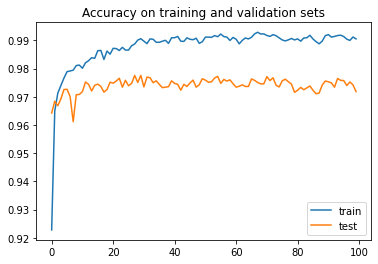

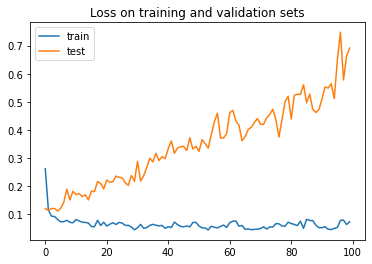

In [22]:
hypermodel = tuner.hypermodel.build(best_hps)

start = time.time()

hypermodel.fit(x_train_pca, y_train, epochs = best_epoch, batch_size=256, validation_split = 0.2)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

As we can see from the learning curves, the model seems to still overfit. Our hope, however, is that we will achieve the maximux accuracy in the test set since the model proved to generalize better when trained for that number of epochs.

Note again that due to the stochastic nature of the procedure, it is yet again possible that we might not achieve the optimal results now that we have retrained the model.

## **Predict on the test set using the optimal model**

A simple way to evaluate the performance of the model is by displaying its confusion matrix from which we can then extract metrics such the accuracy, precision, recall and F1 measure.

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.96      0.98      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.95      0.96       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.87      0.98      0.93       974
           9       0.98      0.95      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



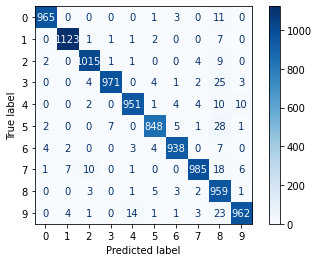

In [23]:
labels = [0,1,2,3,4,5,6,7,8,9]

#Predictions
y_pred = model.predict(x_test_pca, verbose=1)

#Get the value of the predicted label
y_pred_bool = np.argmax(y_pred, axis=1)

#Create and display confusion matrix
M = confusion_matrix(y_test_raw, y_pred_bool)

disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show

#accuracy, precision, recall and f1-score
print(classification_report(y_test_raw, y_pred_bool))

By examining the confusion matrix we can see that in general our model is able to correctly classify most of the samples of the test set. Some cases with which our model seems to struggle are: 9 that is classified as 8 (23 misclassified), 5 that is classified as 8 (28 misclassified) and 3 that is classified as 8 (25 misclassified).

 We can see that the model struggles with some digits and tends to classify them as 8. A way to deal with this would be by using techniques such as bagging or boosting to help the model learn these cases in which it makes a mistake often better.

 As for the rest of the metrics shown, we can see that most of them have pretty satisfying values, but still we haven't managed to achieve a better accuracy than 0.98. 

 Our next move is to try a different network architecture.

## **Examples of predictions**

We will check if our model can predict correctly the first 3 images of the test set.

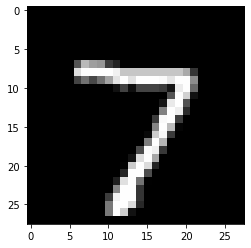

Model prediction: 7


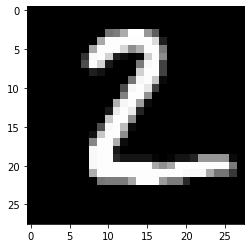

Model prediction: 2


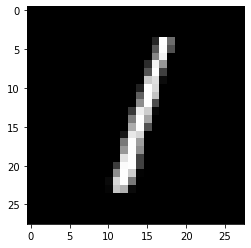

Model prediction: 1


In [24]:
n_images = 3
test_images = x_test[:n_images]
test_images_pca = x_test_pca[:n_images]
predictions = model.predict(test_images_pca)

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions[i]))

As we can see, the model manages to classify all 3 images correctly.

# **Part 3:** Convolutional Neural Networks (CNNs)

So far, we have examined MLPs with layers that are fully connected. A different architecture is that of CNNs in which the receptive field of each neuron in the convolutional layer is limited to only a region of the input instead of the whole input. The main idea is that the first hidden layers will be able to detect more general characteristics and while we go on to the next layers these will combine so that these layers will detect more specific objects such as a dog or a car for example.

Each layer applies a series of filters to small portions of the image and creates a map of features. Then using what we call a pooling layer we undersample these and repeat this process up until we have only as many features as are our classes. it is also typical that there is one more fully connected layers right before the output layer.

In our case the architecture that we use is inspired by the VGGNet model. More specifically, we have 2 convolutional layers that perform 3x3 convolutions (padding used so that output shape is the same as input shape) followed by a 2x2 max pooling reducing the size of each dimension of the output by a factor of 2. This configuration of 2 convolutional layers followed by a max pooling layer is done for one more time before we add a fully connected hidden layer of 128 neurons. The output layer is a fully connected layer that consists of 10 neurons (1 for each label).

In general, CNNs are considered better at classifying images than typical MLPs. It's time to find out whether our model will also outperform the models that we have used so far.

## **Preprocessing the dataset**

In [26]:
#Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

#Convert to float32
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

#Normalize to [0,1]
x_train, x_test = x_train/255.0, x_test/255.0

#One-hot encoding (to increase performance)
y_train, y_test = np_utils.to_categorical(y_train, num_classes), np_utils.to_categorical(y_test, num_classes)

## **Define the model**

Apart from everything else mentioned above about our architecture, we also use batch normalization before each max pooling layer and after the fully connected hidden layer and each convolutional and fully connected layer has its weights initialized using the He Normal initializer. These are because our model is a deep neural network and we want to avoid the problems mentioned in the related sections of part 1.

Moreover, it is worth noticing that most of the trainable variables belong to the fully connected hidden layer. A big advantage of CNNs is that convolutional layers have only a relatably small number of weights due to parameter-sharing. This way we can have many convolutional layers without making the model a lot more complex.

In [10]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation='relu',input_shape=(28,28,1),
                            kernel_initializer=initializers.HeNormal()))

cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation='relu',
                            kernel_initializer=initializers.HeNormal()))

cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.MaxPooling2D(pool_size=(2,2)))

cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu',input_shape=(28,28,1),
                            kernel_initializer=initializers.HeNormal()))

cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu',
                            kernel_initializer=initializers.HeNormal()))

cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.MaxPooling2D(pool_size=(2,2)))

cnn_model.add(layers.Flatten())

cnn_model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()))

cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Dense(10))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        3

## **Train the model**

Due to their architecture, CNNs can be fastly trained by using GPUs. For the specific model, the acceleration we managed to achieve in comparison to a CPU was x50-100.

For the training process, we are using the Adam algorithm here, too, with learning rate of 0.001. The training is done for 20 epochs. We can also use techniques such as early stopping or regularization here to avoid overfitting, but this was omitted for the sake of simplicity.

Epoch 1/20
188/188 [==============================] - 201s 1s/step - loss: 0.0325 - accuracy: 0.9900 - val_loss: 0.0474 - val_accuracy: 0.9850
Epoch 2/20
188/188 [==============================] - 200s 1s/step - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.0549 - val_accuracy: 0.9836
Epoch 3/20
188/188 [==============================] - 201s 1s/step - loss: 0.0087 - accuracy: 0.9979 - val_loss: 0.0363 - val_accuracy: 0.9897
Epoch 4/20
188/188 [==============================] - 201s 1s/step - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.0452 - val_accuracy: 0.9868
Epoch 5/20
188/188 [==============================] - 200s 1s/step - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.0568 - val_accuracy: 0.9835
Epoch 6/20
188/188 [==============================] - 200s 1s/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0371 - val_accuracy: 0.9894
Epoch 7/20
188/188 [==============================] - 200s 1s/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.0280 - val_accuracy: 0.9923

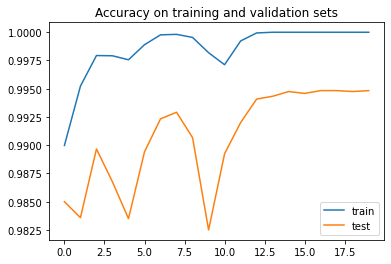

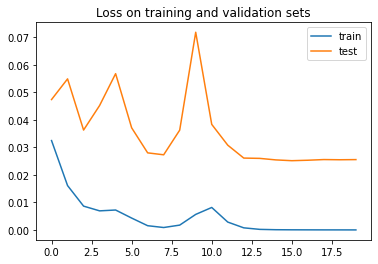

313/313 [==============================] - 11s 35ms/step - loss: 0.0203 - accuracy: 0.9943
Test accuracy: 0.9943000078201294


In [27]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

start = time.time()

#Train model
history = cnn_model.fit(x_train, y_train, epochs=20, batch_size=256, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {}s\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('Accuracy on training and validation sets')
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

score = cnn_model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

As we can clearly see, the model outperforms all models that we have tried up until now achieving an accuracy of 0.994. We also notice from the learning curves that the model manages to perfectly fit the training set but without overfitting and losing its ability to generalize, which is why it also performs so well in the validation and test set.

**Note**: Unfortunately due to time restrictions in Google Colab, I was unable to train the CNN model using a GPU. When trained with a GPU about 3-4 minutes are needed in comparison to roughly 1-2 hours needed with a CPU.

## **Noisy Input**

A way to see if our model is able to generalize well is by adding some noise to the images in the test set and see how well it performs.

In this case, we will add some white noise to the images in the test set, check the accuracy of the model and see if it can correctly classify the first 3 images of the noisy test set.

313/313 [==============================] - 11s 34ms/step - loss: 0.4985 - accuracy: 0.8473
Test accuracy: 0.8472999930381775
Model prediction: 7
Model prediction: 2
Model prediction: 8


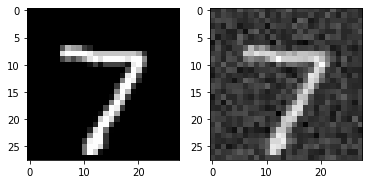

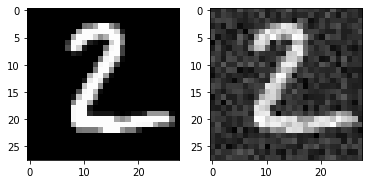

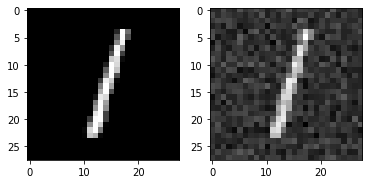

In [28]:
mean = 0.1
std = 0.1
noise = np.random.normal(mean, std, x_test[0].shape) 

x_test_noisy = x_test + noise

score = cnn_model.evaluate(x_test_noisy, y_test)
print('Test accuracy:', score[1])

n_images = 3
test_images = x_test[:n_images]
test_images_noisy = x_test_noisy[:n_images]
predictions = cnn_model.predict(test_images_noisy)

for i in range(n_images):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    axs[1].imshow(np.reshape(test_images_noisy[i], [28, 28]), cmap='gray')
    print("Model prediction: %i" % np.argmax(predictions[i]))

By adding a relatively small amount of noise in the test set, we can see that the predictive ability of the model is reduced. Adding even more noise would cause the accuracy of the model to drop even further.

We have also included 3 examples of clear and noisy images to demonstrate how noise affects the model. As we can see, the model correctly classifies the first 2 images but is unable to classify the last one thinking that this noisy image of 1 is actually an 8.

It is worth mentioning that while these noisy images are still pretty clear for the human eye, the network seems to struggle already.